<a href="https://colab.research.google.com/github/pravinkr/GAN-MNIST/blob/master/Implementing_GAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,  Dropout, Flatten, Dense, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from PIL import Image
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def build_discriminator(image_shape):

  input_shape = image_shape
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,(3,3), strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3,3), strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(1,activation='sigmoid'))

  #output = model
  #inp = Input(shape=input_shape) 

  
  #model.summary()

  input_image = Input(shape=input_shape)

  validity = model(input_image)

  return Model(input_image,validity)

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
#x_train.shape


In [80]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras.layers import UpSampling2D, BatchNormalization, Activation, ReLU, Reshape, Conv2DTranspose


In [0]:
def build_generator(seed_size,channels):

  model = Sequential()
  model.add(Dense(7*7*256, input_dim=seed_size))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Activation('relu'))

  model.add(Reshape((7,7,256)))
  model.add(Dropout(0.4))

  model.add(Conv2DTranspose(128,(5,5),padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Activation('relu'))
  model.add(UpSampling2D())

  model.add(Conv2DTranspose(64,(3,3),padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Activation('relu'))
  model.add(UpSampling2D())

  model.add(Conv2DTranspose(32,(3,3),padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Activation('relu'))

  model.add(Conv2DTranspose(1,(3,3),padding='same'))
  model.add(Activation('sigmoid'))

  input = Input(shape=(seed_size,))

  generated_image = model(input)

  #model.summary()

  return(Model(input,generated_image))

In [0]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)


image_shape = (28,28,1)
seed_size = 100

#Get the discriminator and generator Models
discriminator = build_discriminator(image_shape)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator(seed_size,1)

random_input = Input(shape=(seed_size,))
generated_image = generator(random_input)

discriminator.trainable = False
validity = discriminator(generated_image)

combined = Model(random_input, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


In [84]:
def plot_images( x_train,save2file=False, fake=True, samples=16, noise=None, step=0,dim=(1, 10),figsize=(12, 2)):

        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.normal(0, 1, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = generator.predict(noise)
        else:
            i = np.random.randint(0, x_train.shape[0], samples)
            images = x_train[i, :, :, :]



        plt.figure(figsize=figsize)
        for i in range(images.shape[0]):
          plt.subplot(dim[0], dim[1], i+1)
          plt.imshow(images[i, :, :], interpolation='nearest', cmap='gray_r')
          plt.axis('off')
          plt.tight_layout()
 
        if save2file:
          plt.savefig(filename)
          plt.close('all')
        else:
          plt.show()

'''
        plt.figure(figsize=figsize)
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [28, 28])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
'''


"\n        plt.figure(figsize=figsize)\n        for i in range(images.shape[0]):\n            plt.subplot(4, 4, i+1)\n            image = images[i, :, :, :]\n            image = np.reshape(image, [28, 28])\n            plt.imshow(image, cmap='gray')\n            plt.axis('off')\n        plt.tight_layout()\n"

In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [86]:
import numpy as np
SEED_SIZE = 100
batch_size=32
EPOCHS = 10000
y_real = np.ones((batch_size,1))
y_fake = np.zeros((batch_size,1))
fixed_seed = np.random.uniform(-1,1,size=[28,SEED_SIZE])
SAVE_FREQ = 100
fixed_seed.shape

(28, 100)

In [0]:
def plot_generated(noise, n_ex=10, dim=(1, 10), figsize=(12, 2)):
    #if noise == None:
    #  noise = np.random.uniform(-1.0, 1.0, size=(n_ex, SEED_SIZE))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


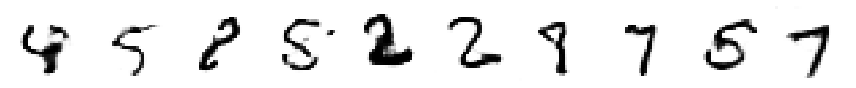

Epoch 0, discriminator Accurancy: [0.68391496, 0.578125], Generator Accuracy: [0.69759643, 0.59375]


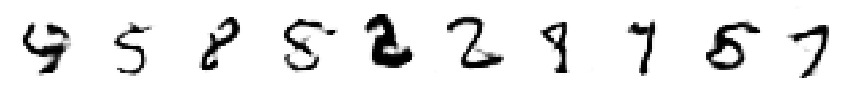

Epoch 100, discriminator Accurancy: [0.7104907, 0.59375], Generator Accuracy: [0.76049685, 0.40625]


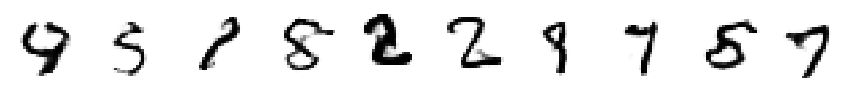

Epoch 200, discriminator Accurancy: [0.6962699, 0.578125], Generator Accuracy: [0.8419367, 0.28125]


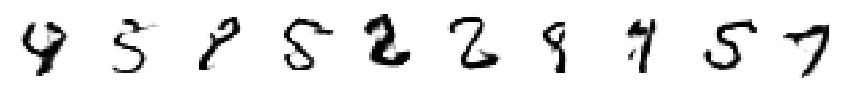

Epoch 300, discriminator Accurancy: [0.68561256, 0.578125], Generator Accuracy: [0.85006684, 0.21875]


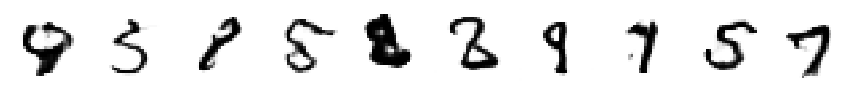

Epoch 400, discriminator Accurancy: [0.72626245, 0.515625], Generator Accuracy: [0.9492088, 0.1875]


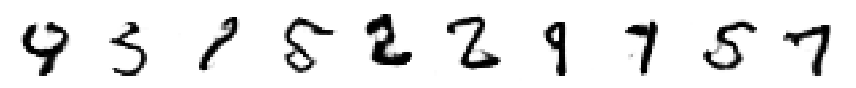

Epoch 500, discriminator Accurancy: [0.67684966, 0.578125], Generator Accuracy: [0.78186, 0.28125]


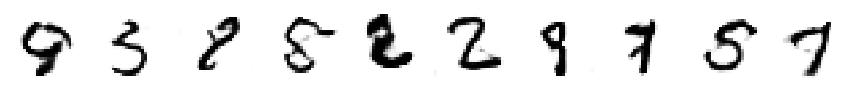

Epoch 600, discriminator Accurancy: [0.7273648, 0.5625], Generator Accuracy: [1.0183543, 0.15625]


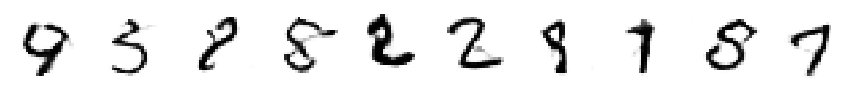

Epoch 700, discriminator Accurancy: [0.6740954, 0.625], Generator Accuracy: [0.8450345, 0.28125]


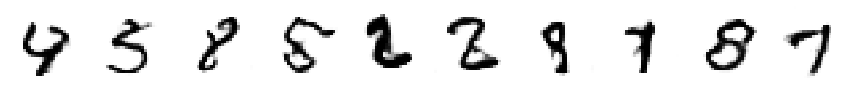

Epoch 800, discriminator Accurancy: [0.68856674, 0.578125], Generator Accuracy: [0.7870344, 0.25]


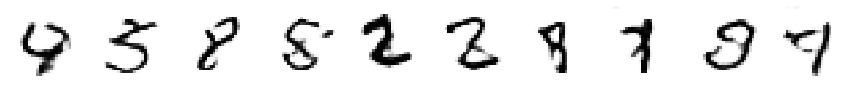

Epoch 900, discriminator Accurancy: [0.682953, 0.5625], Generator Accuracy: [0.8678497, 0.34375]


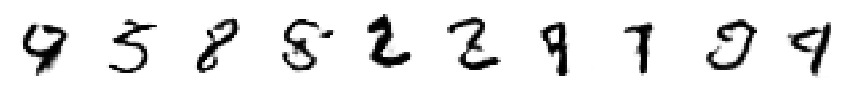

Epoch 1000, discriminator Accurancy: [0.71188724, 0.46875], Generator Accuracy: [1.0336537, 0.125]


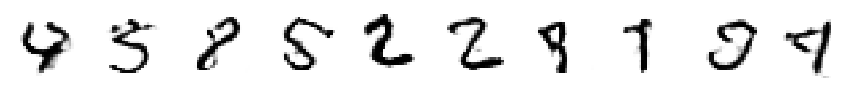

Epoch 1100, discriminator Accurancy: [0.67838085, 0.53125], Generator Accuracy: [1.1528046, 0.03125]


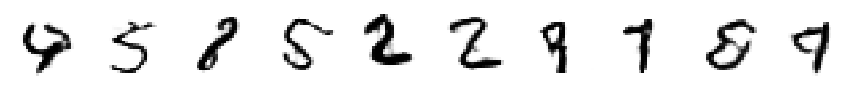

Epoch 1200, discriminator Accurancy: [0.67970836, 0.59375], Generator Accuracy: [0.8333162, 0.25]


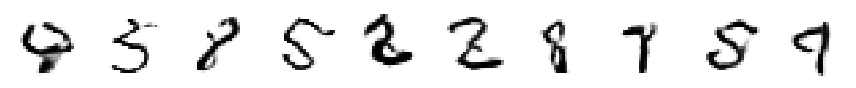

Epoch 1300, discriminator Accurancy: [0.7118093, 0.515625], Generator Accuracy: [0.8092308, 0.3125]


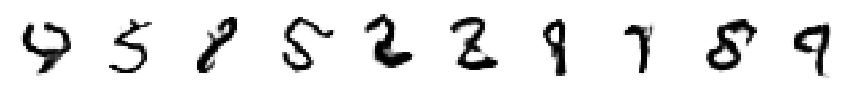

Epoch 1400, discriminator Accurancy: [0.66278887, 0.625], Generator Accuracy: [0.83833134, 0.4375]


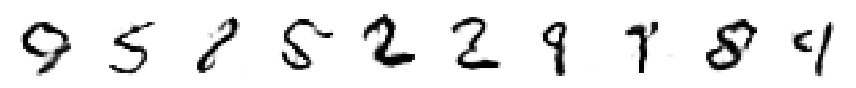

Epoch 1500, discriminator Accurancy: [0.65918124, 0.609375], Generator Accuracy: [1.0073605, 0.125]


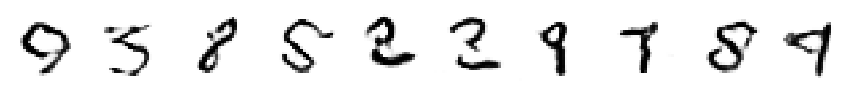

Epoch 1600, discriminator Accurancy: [0.6896465, 0.59375], Generator Accuracy: [0.6962588, 0.53125]


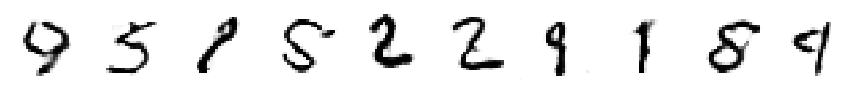

Epoch 1700, discriminator Accurancy: [0.7118975, 0.484375], Generator Accuracy: [0.7865793, 0.34375]


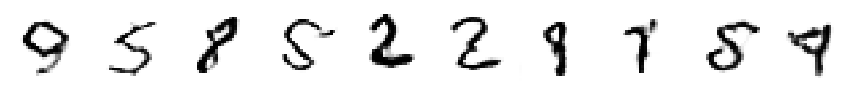

Epoch 1800, discriminator Accurancy: [0.7008518, 0.53125], Generator Accuracy: [0.94508857, 0.21875]


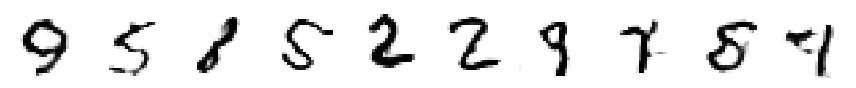

Epoch 1900, discriminator Accurancy: [0.7085204, 0.484375], Generator Accuracy: [0.71501535, 0.53125]


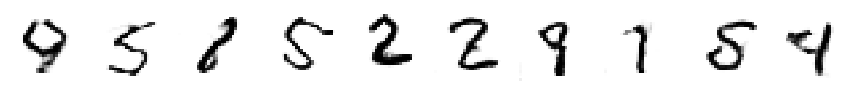

Epoch 2000, discriminator Accurancy: [0.6379517, 0.609375], Generator Accuracy: [0.81879175, 0.28125]


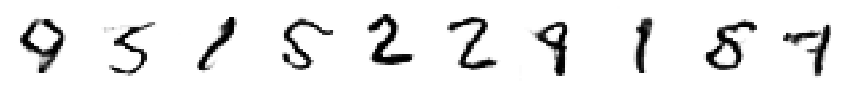

Epoch 2100, discriminator Accurancy: [0.7158732, 0.625], Generator Accuracy: [0.8070964, 0.46875]


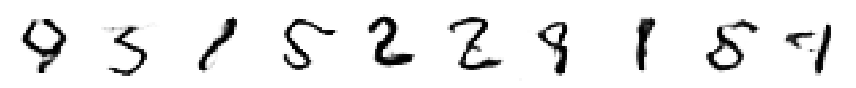

Epoch 2200, discriminator Accurancy: [0.7023236, 0.578125], Generator Accuracy: [0.8833035, 0.28125]


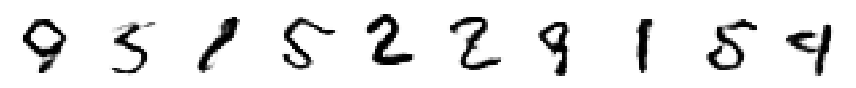

Epoch 2300, discriminator Accurancy: [0.6202615, 0.640625], Generator Accuracy: [0.67977506, 0.5]


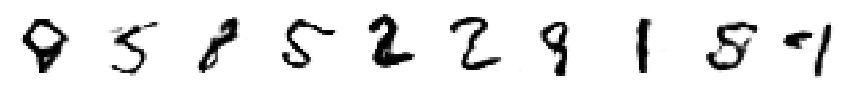

Epoch 2400, discriminator Accurancy: [0.65827084, 0.640625], Generator Accuracy: [0.7845019, 0.40625]


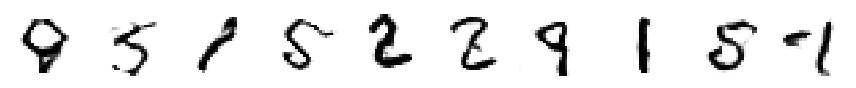

Epoch 2500, discriminator Accurancy: [0.76678514, 0.4375], Generator Accuracy: [0.7949484, 0.34375]


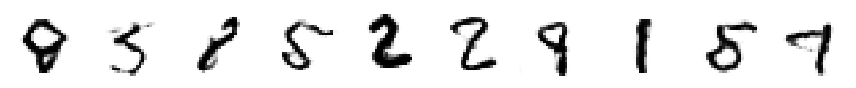

Epoch 2600, discriminator Accurancy: [0.6514507, 0.625], Generator Accuracy: [0.8351498, 0.34375]


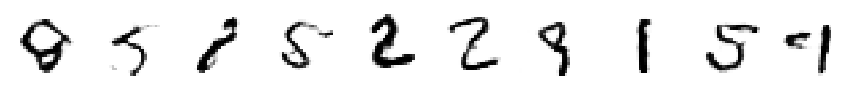

Epoch 2700, discriminator Accurancy: [0.70036054, 0.5625], Generator Accuracy: [0.64253277, 0.65625]


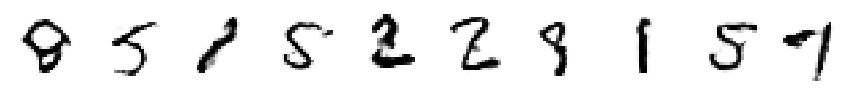

Epoch 2800, discriminator Accurancy: [0.6671529, 0.59375], Generator Accuracy: [0.71804386, 0.46875]


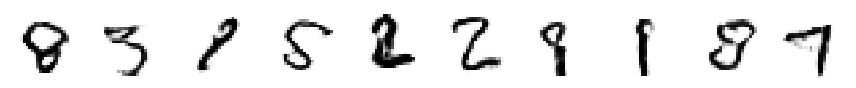

Epoch 2900, discriminator Accurancy: [0.6666842, 0.546875], Generator Accuracy: [0.8148838, 0.34375]


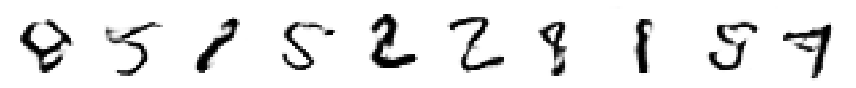

Epoch 3000, discriminator Accurancy: [0.6990243, 0.5625], Generator Accuracy: [0.85676897, 0.34375]


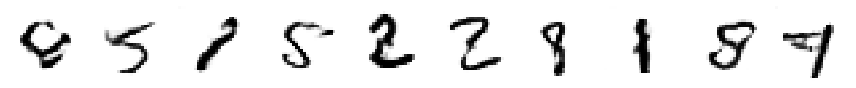

Epoch 3100, discriminator Accurancy: [0.6820048, 0.609375], Generator Accuracy: [0.68656397, 0.53125]


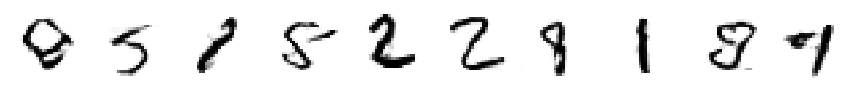

Epoch 3200, discriminator Accurancy: [0.6935515, 0.5], Generator Accuracy: [0.86972654, 0.3125]


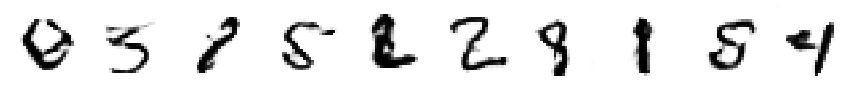

Epoch 3300, discriminator Accurancy: [0.64007586, 0.59375], Generator Accuracy: [0.65798134, 0.59375]


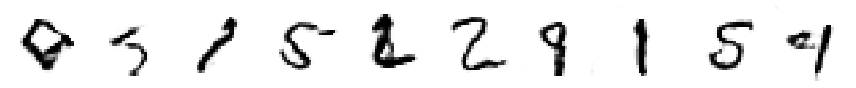

Epoch 3400, discriminator Accurancy: [0.6800624, 0.578125], Generator Accuracy: [0.6814942, 0.5625]


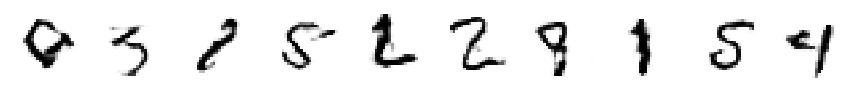

Epoch 3500, discriminator Accurancy: [0.66055524, 0.59375], Generator Accuracy: [0.8420092, 0.3125]


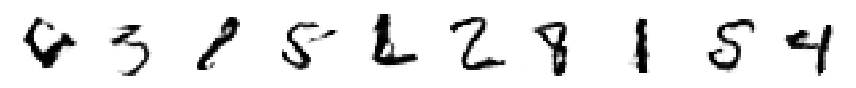

Epoch 3600, discriminator Accurancy: [0.6534115, 0.640625], Generator Accuracy: [0.8540398, 0.3125]


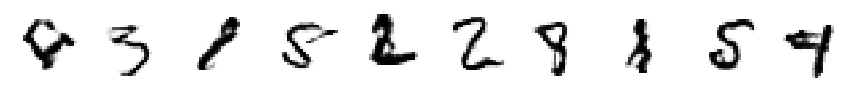

Epoch 3700, discriminator Accurancy: [0.68665045, 0.546875], Generator Accuracy: [0.7930796, 0.40625]


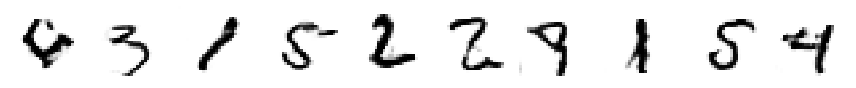

Epoch 3800, discriminator Accurancy: [0.64840484, 0.640625], Generator Accuracy: [0.6845614, 0.59375]


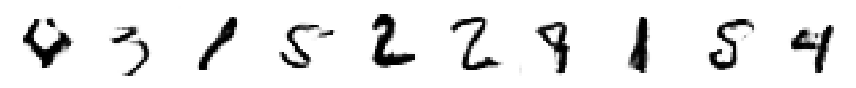

Epoch 3900, discriminator Accurancy: [0.71102655, 0.515625], Generator Accuracy: [0.9058681, 0.03125]


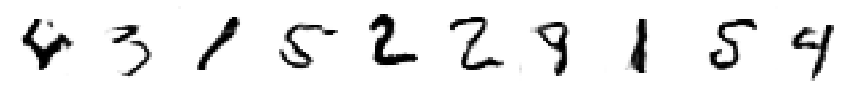

Epoch 4000, discriminator Accurancy: [0.71429205, 0.546875], Generator Accuracy: [0.97159374, 0.1875]


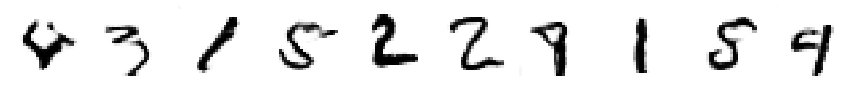

Epoch 4100, discriminator Accurancy: [0.651515, 0.578125], Generator Accuracy: [0.8247471, 0.3125]


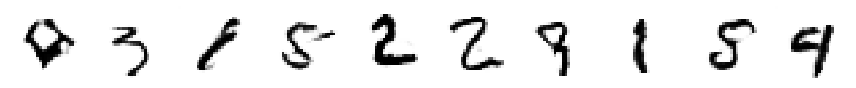

Epoch 4200, discriminator Accurancy: [0.6884369, 0.640625], Generator Accuracy: [0.79437155, 0.375]


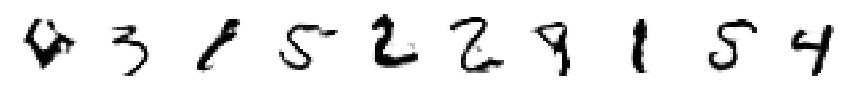

Epoch 4300, discriminator Accurancy: [0.66912663, 0.546875], Generator Accuracy: [0.8986664, 0.21875]


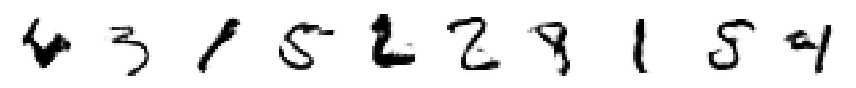

Epoch 4400, discriminator Accurancy: [0.68642414, 0.5], Generator Accuracy: [0.75877714, 0.34375]


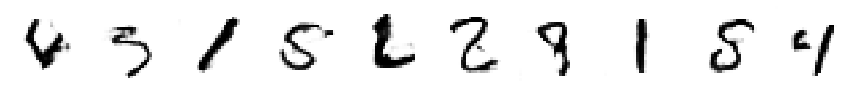

Epoch 4500, discriminator Accurancy: [0.6935388, 0.609375], Generator Accuracy: [1.0020502, 0.1875]


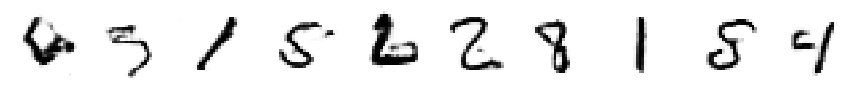

Epoch 4600, discriminator Accurancy: [0.651782, 0.65625], Generator Accuracy: [0.7853359, 0.34375]


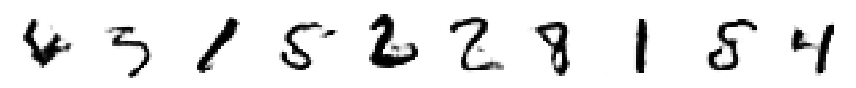

Epoch 4700, discriminator Accurancy: [0.67078865, 0.515625], Generator Accuracy: [0.7938038, 0.28125]


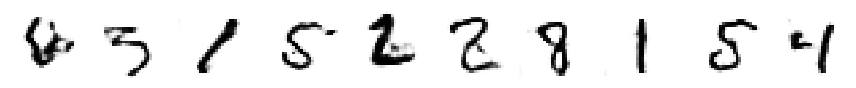

Epoch 4800, discriminator Accurancy: [0.63746697, 0.578125], Generator Accuracy: [0.7234365, 0.53125]


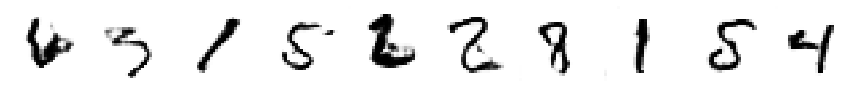

Epoch 4900, discriminator Accurancy: [0.60970384, 0.65625], Generator Accuracy: [0.76340985, 0.40625]


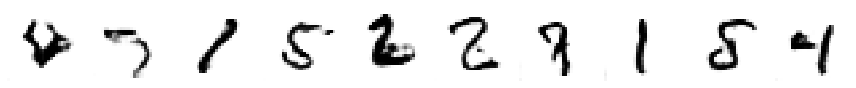

Epoch 5000, discriminator Accurancy: [0.70612955, 0.53125], Generator Accuracy: [0.92669326, 0.0625]


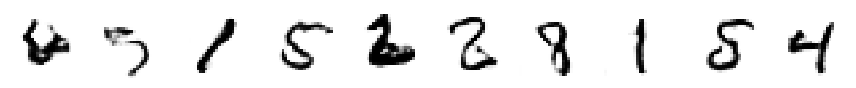

Epoch 5100, discriminator Accurancy: [0.6327234, 0.625], Generator Accuracy: [0.8027558, 0.375]


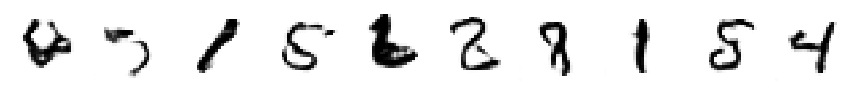

Epoch 5200, discriminator Accurancy: [0.61023635, 0.65625], Generator Accuracy: [0.70552087, 0.5625]


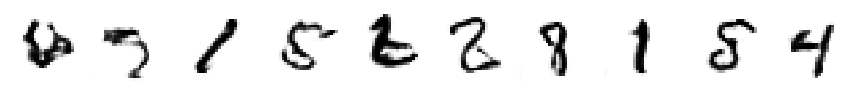

Epoch 5300, discriminator Accurancy: [0.6220586, 0.65625], Generator Accuracy: [0.83317286, 0.21875]


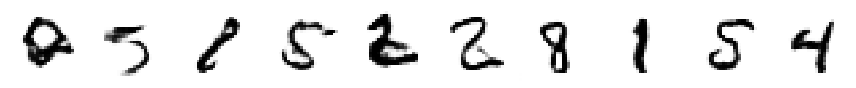

Epoch 5400, discriminator Accurancy: [0.6923958, 0.546875], Generator Accuracy: [0.7918591, 0.40625]


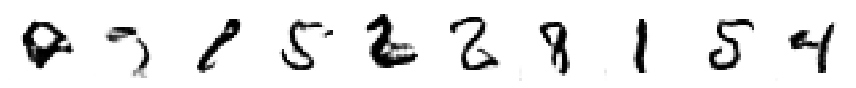

Epoch 5500, discriminator Accurancy: [0.6783735, 0.5625], Generator Accuracy: [0.7472556, 0.40625]


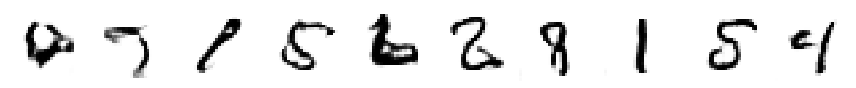

Epoch 5600, discriminator Accurancy: [0.65516496, 0.65625], Generator Accuracy: [0.8624102, 0.21875]


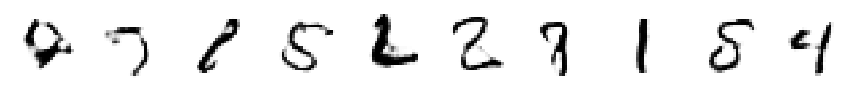

Epoch 5700, discriminator Accurancy: [0.6490494, 0.609375], Generator Accuracy: [0.9141673, 0.3125]


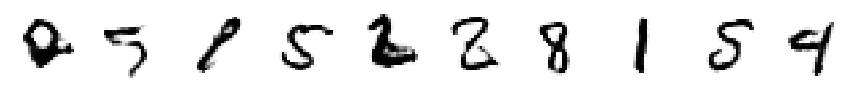

Epoch 5800, discriminator Accurancy: [0.6503685, 0.65625], Generator Accuracy: [0.74232316, 0.40625]


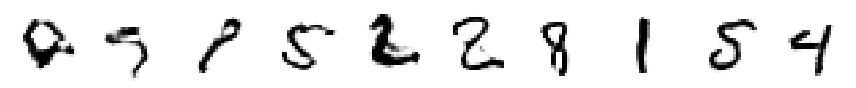

Epoch 5900, discriminator Accurancy: [0.67834866, 0.640625], Generator Accuracy: [0.8348775, 0.3125]


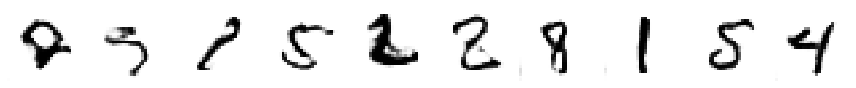

Epoch 6000, discriminator Accurancy: [0.6454303, 0.59375], Generator Accuracy: [0.8095307, 0.3125]


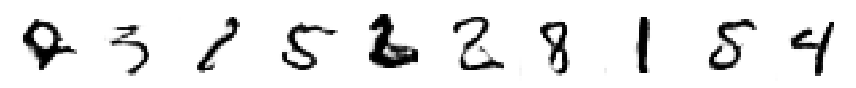

Epoch 6100, discriminator Accurancy: [0.662091, 0.59375], Generator Accuracy: [0.93200326, 0.21875]


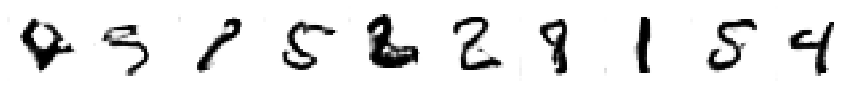

Epoch 6200, discriminator Accurancy: [0.6810969, 0.515625], Generator Accuracy: [0.8201537, 0.3125]


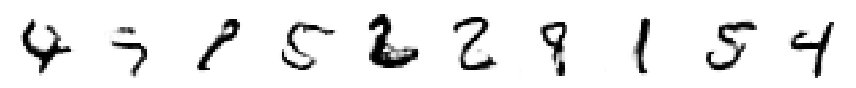

Epoch 6300, discriminator Accurancy: [0.6552788, 0.59375], Generator Accuracy: [0.7120352, 0.5625]


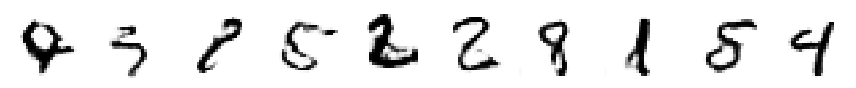

Epoch 6400, discriminator Accurancy: [0.66192377, 0.5625], Generator Accuracy: [0.89251685, 0.21875]


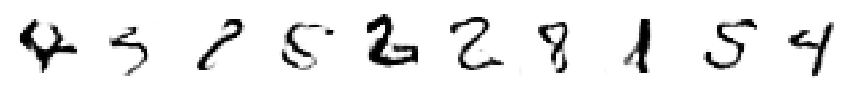

Epoch 6500, discriminator Accurancy: [0.6936076, 0.546875], Generator Accuracy: [0.81620836, 0.34375]


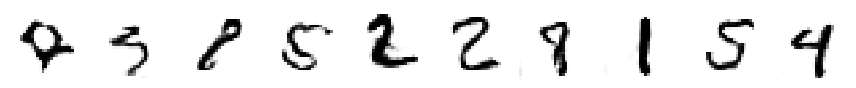

Epoch 6600, discriminator Accurancy: [0.6764307, 0.625], Generator Accuracy: [0.82401586, 0.28125]


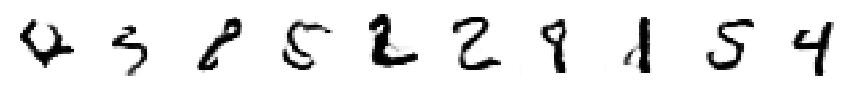

Epoch 6700, discriminator Accurancy: [0.6531377, 0.625], Generator Accuracy: [0.8321732, 0.3125]


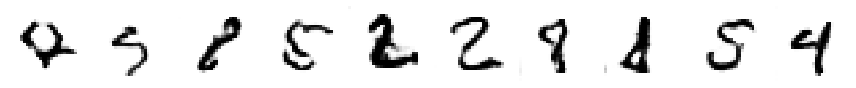

Epoch 6800, discriminator Accurancy: [0.72066563, 0.4375], Generator Accuracy: [0.75857687, 0.3125]


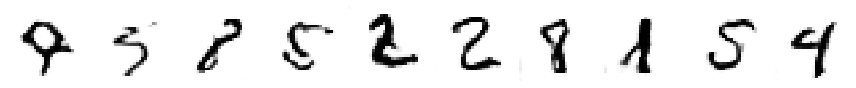

Epoch 6900, discriminator Accurancy: [0.6960596, 0.484375], Generator Accuracy: [0.73478174, 0.40625]


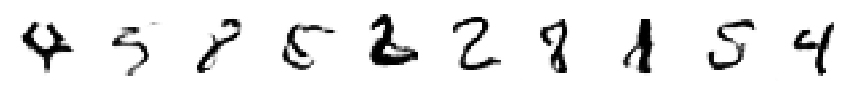

Epoch 7000, discriminator Accurancy: [0.6993267, 0.484375], Generator Accuracy: [0.7887819, 0.3125]


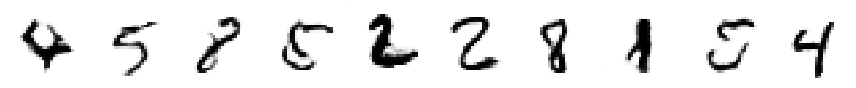

Epoch 7100, discriminator Accurancy: [0.6902469, 0.546875], Generator Accuracy: [0.83067876, 0.25]


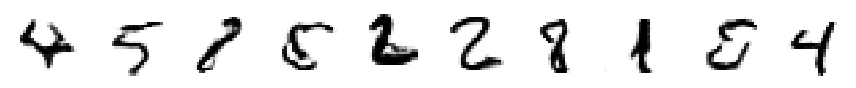

Epoch 7200, discriminator Accurancy: [0.7699384, 0.484375], Generator Accuracy: [0.8143203, 0.28125]


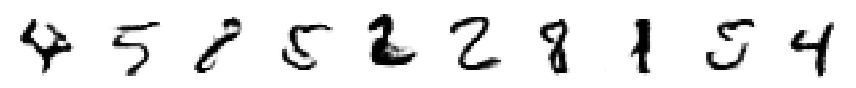

Epoch 7300, discriminator Accurancy: [0.6894329, 0.5625], Generator Accuracy: [0.769569, 0.34375]


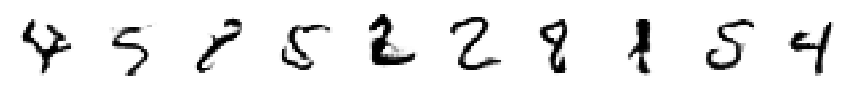

Epoch 7400, discriminator Accurancy: [0.677179, 0.578125], Generator Accuracy: [0.78109205, 0.4375]


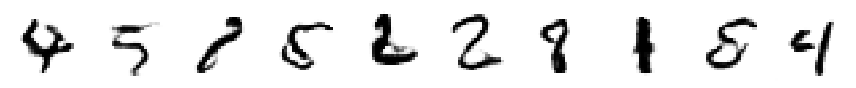

Epoch 7500, discriminator Accurancy: [0.71113145, 0.609375], Generator Accuracy: [0.7986052, 0.25]


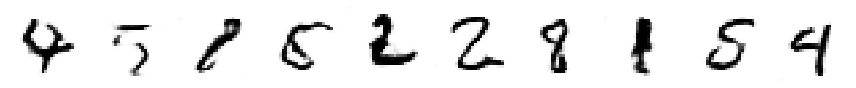

Epoch 7600, discriminator Accurancy: [0.680226, 0.59375], Generator Accuracy: [0.60477215, 0.6875]


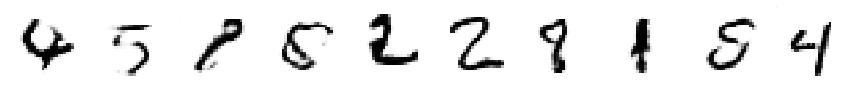

Epoch 7700, discriminator Accurancy: [0.62532943, 0.65625], Generator Accuracy: [0.7788512, 0.40625]


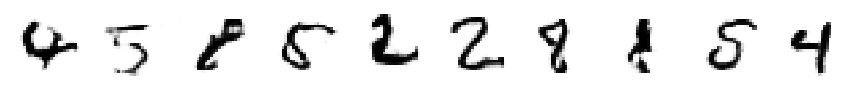

Epoch 7800, discriminator Accurancy: [0.7076603, 0.53125], Generator Accuracy: [1.0051694, 0.09375]


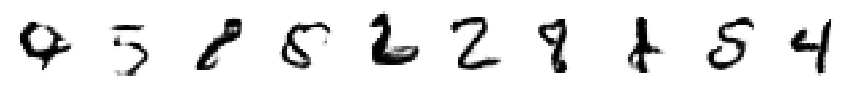

Epoch 7900, discriminator Accurancy: [0.6523355, 0.640625], Generator Accuracy: [0.75733507, 0.40625]


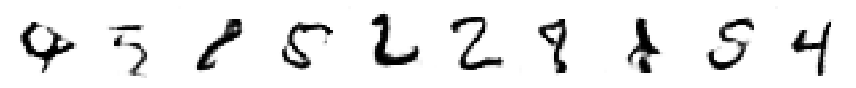

Epoch 8000, discriminator Accurancy: [0.6791462, 0.578125], Generator Accuracy: [0.71699, 0.46875]


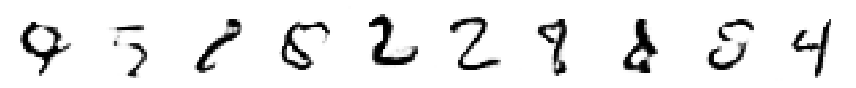

Epoch 8100, discriminator Accurancy: [0.6699828, 0.640625], Generator Accuracy: [0.91445935, 0.21875]


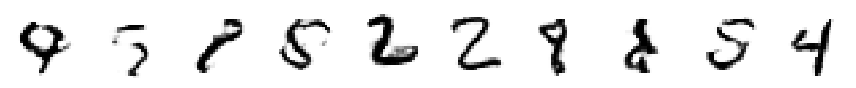

Epoch 8200, discriminator Accurancy: [0.68426347, 0.546875], Generator Accuracy: [1.0271077, 0.03125]


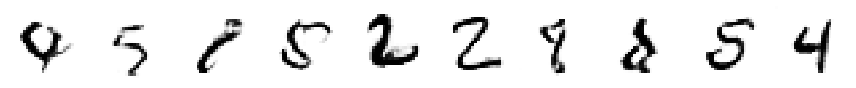

Epoch 8300, discriminator Accurancy: [0.64654934, 0.609375], Generator Accuracy: [0.7211912, 0.46875]


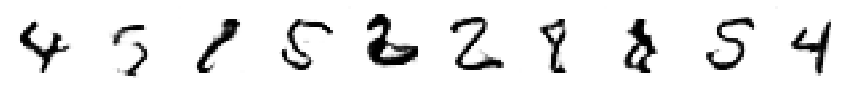

Epoch 8400, discriminator Accurancy: [0.7234534, 0.421875], Generator Accuracy: [0.71803856, 0.40625]


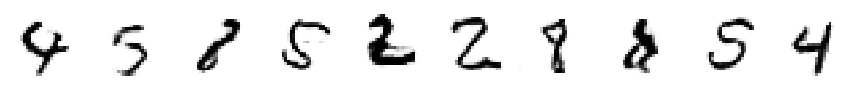

Epoch 8500, discriminator Accurancy: [0.6370486, 0.640625], Generator Accuracy: [0.84663516, 0.21875]


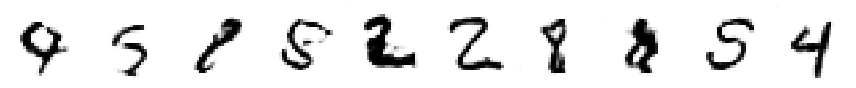

Epoch 8600, discriminator Accurancy: [0.68267167, 0.5625], Generator Accuracy: [0.8986718, 0.3125]


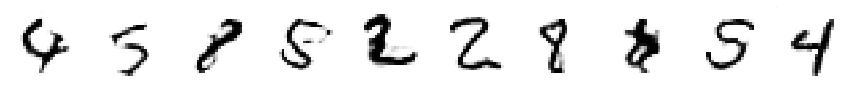

Epoch 8700, discriminator Accurancy: [0.6491928, 0.640625], Generator Accuracy: [0.7407463, 0.4375]


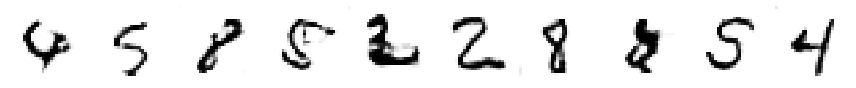

Epoch 8800, discriminator Accurancy: [0.67620766, 0.546875], Generator Accuracy: [0.773206, 0.40625]


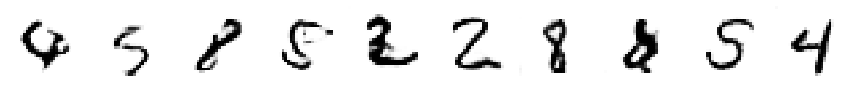

Epoch 8900, discriminator Accurancy: [0.6500604, 0.609375], Generator Accuracy: [0.74141085, 0.4375]


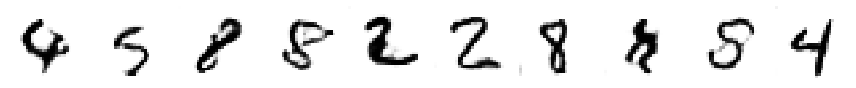

Epoch 9000, discriminator Accurancy: [0.69346595, 0.5625], Generator Accuracy: [0.81156945, 0.28125]


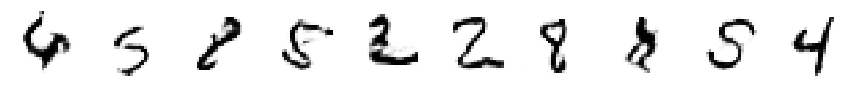

Epoch 9100, discriminator Accurancy: [0.7001618, 0.53125], Generator Accuracy: [0.7113309, 0.5625]


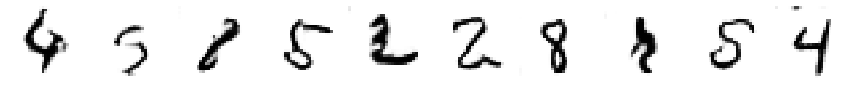

Epoch 9200, discriminator Accurancy: [0.68060035, 0.546875], Generator Accuracy: [0.8153244, 0.1875]


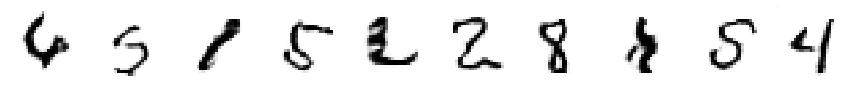

Epoch 9300, discriminator Accurancy: [0.7321651, 0.484375], Generator Accuracy: [0.79701376, 0.1875]


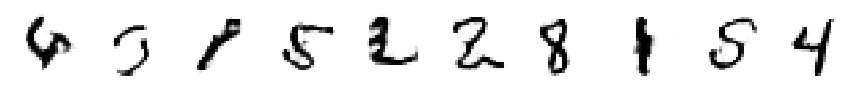

Epoch 9400, discriminator Accurancy: [0.7641077, 0.515625], Generator Accuracy: [0.98183024, 0.15625]


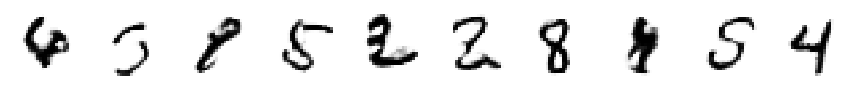

Epoch 9500, discriminator Accurancy: [0.65969807, 0.625], Generator Accuracy: [0.81867874, 0.25]


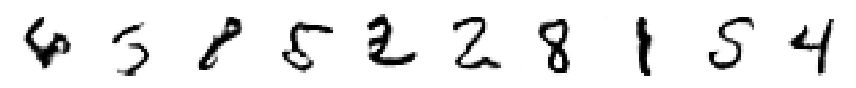

Epoch 9600, discriminator Accurancy: [0.68854237, 0.609375], Generator Accuracy: [0.81438017, 0.3125]


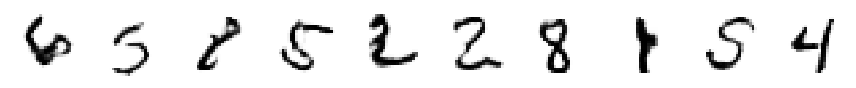

Epoch 9700, discriminator Accurancy: [0.69996655, 0.484375], Generator Accuracy: [0.7463077, 0.3125]


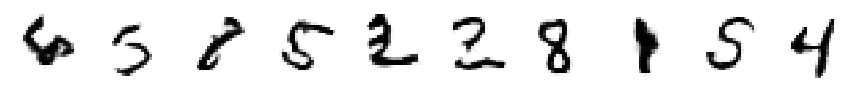

Epoch 9800, discriminator Accurancy: [0.7124328, 0.515625], Generator Accuracy: [0.711251, 0.53125]


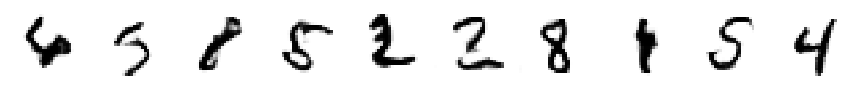

Epoch 9900, discriminator Accurancy: [0.72953105, 0.5], Generator Accuracy: [0.73169744, 0.40625]


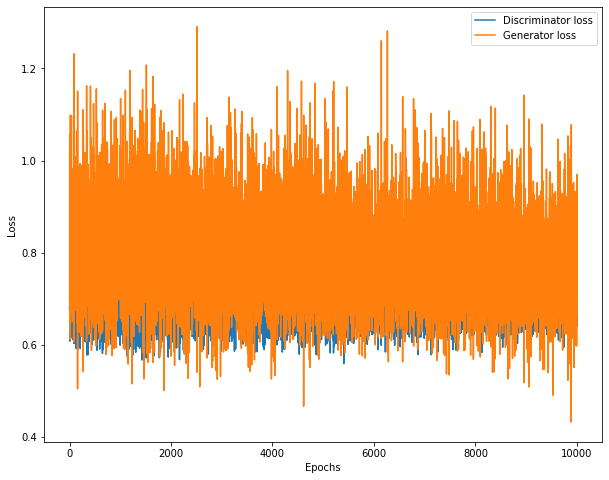

In [93]:

#fixed_seed = np.random.normal(0,1,size=[batch_size,seed_size])
#np.random.seed(42)


cnt = 1

noise_input = np.random.normal(0,1,size=[10,SEED_SIZE])

#Setup loss vector to store losses for Generator and Discriminator

losses = {"D":[], "G":[]}

for epoch in range(EPOCHS):

  noise = np.random.normal(0,1,size=[batch_size,SEED_SIZE])

  idx = np.random.randint(0,x_train.shape[0],size=batch_size)
  #print(idx[0:10])
  x_real = x_train[idx]

  #print("x_real.shape",x_real.shape)

  #Generate some images
  #noise = np.random.uniform(-1.0,1.0,size=[batch_size,SEED_SIZE])
  
  x_fake = generator.predict(noise)

  x = np.concatenate((x_real,x_fake))

  y = np.ones([2*batch_size,1])
  y[batch_size:,:] = 0

  #Train discriminator on real and fake

  discriminator_metric = discriminator.train_on_batch(x,y)
  #discriminator_metric_generated = discriminator.train_on_batch(x_fake,y_fake)

  #discriminator_metric = 0.5 * np.add(discriminator_metric_real, discriminator_metric_generated)

  #Train Generator on Calculated loss

  y = np.ones([batch_size, 1])
  #noise = np.random.uniform(-1.0, 1.0, size=[batch_size, SEED_SIZE])
  noise = np.random.normal(0,1,size=[batch_size,SEED_SIZE])

  generator_metric = combined.train_on_batch(noise,y)

  losses["D"].append(discriminator_metric)
  losses["G"].append(generator_metric)


  #Time for an update

  if SAVE_FREQ > 0:
    if epoch % SAVE_FREQ == 0:

      #save2file = True will display the image on screen. False will save the image in png format on disk

      #plot_images(x_train,save2file=False, samples=noise_input.shape[0],noise=noise_input, step=cnt)
      #plot_images(x_train,save2file=True, samples=noise_input.shape[0],noise=noise_input, step=cnt)

      plot_generated(noise_input,n_ex=10, dim=(1,10),figsize=(12,2))
      print(f"Epoch {epoch}, discriminator Accurancy: {discriminator_metric}, Generator Accuracy: {generator_metric}")
      cnt+=1


plot_loss(losses)

In [89]:
!ls -ltr

total 788
drwxr-xr-x 1 root root 4096 Dec 18 16:52 sample_data
drwx------ 4 root root 4096 Jan  7 16:42 gdrive
-rw-r--r-- 1 root root 7570 Jan  7 17:06 mnist_6.png
-rw-r--r-- 1 root root 7566 Jan  7 17:06 mnist_7.png
-rw-r--r-- 1 root root 7476 Jan  7 17:06 mnist_8.png
-rw-r--r-- 1 root root 7611 Jan  7 17:06 mnist_9.png
-rw-r--r-- 1 root root 7648 Jan  7 17:06 mnist_10.png
-rw-r--r-- 1 root root 7632 Jan  7 17:06 mnist_11.png
-rw-r--r-- 1 root root 7597 Jan  7 17:06 mnist_12.png
-rw-r--r-- 1 root root 7645 Jan  7 17:06 mnist_13.png
-rw-r--r-- 1 root root 7791 Jan  7 17:06 mnist_14.png
-rw-r--r-- 1 root root 7712 Jan  7 17:06 mnist_15.png
-rw-r--r-- 1 root root 7591 Jan  7 17:06 mnist_16.png
-rw-r--r-- 1 root root 7657 Jan  7 17:06 mnist_17.png
-rw-r--r-- 1 root root 7625 Jan  7 17:06 mnist_18.png
-rw-r--r-- 1 root root 7622 Jan  7 17:06 mnist_19.png
-rw-r--r-- 1 root root 7998 Jan  7 17:06 mnist_20.png
-rw-r--r-- 1 root root 7628 Jan  7 17:06 mnist_21.png
-rw-r--r-- 1 root root 7566 J

In [90]:
!pwd

/content


In [91]:
!ls -ltr

total 788
drwxr-xr-x 1 root root 4096 Dec 18 16:52 sample_data
drwx------ 4 root root 4096 Jan  7 16:42 gdrive
-rw-r--r-- 1 root root 7570 Jan  7 17:06 mnist_6.png
-rw-r--r-- 1 root root 7566 Jan  7 17:06 mnist_7.png
-rw-r--r-- 1 root root 7476 Jan  7 17:06 mnist_8.png
-rw-r--r-- 1 root root 7611 Jan  7 17:06 mnist_9.png
-rw-r--r-- 1 root root 7648 Jan  7 17:06 mnist_10.png
-rw-r--r-- 1 root root 7632 Jan  7 17:06 mnist_11.png
-rw-r--r-- 1 root root 7597 Jan  7 17:06 mnist_12.png
-rw-r--r-- 1 root root 7645 Jan  7 17:06 mnist_13.png
-rw-r--r-- 1 root root 7791 Jan  7 17:06 mnist_14.png
-rw-r--r-- 1 root root 7712 Jan  7 17:06 mnist_15.png
-rw-r--r-- 1 root root 7591 Jan  7 17:06 mnist_16.png
-rw-r--r-- 1 root root 7657 Jan  7 17:06 mnist_17.png
-rw-r--r-- 1 root root 7625 Jan  7 17:06 mnist_18.png
-rw-r--r-- 1 root root 7622 Jan  7 17:06 mnist_19.png
-rw-r--r-- 1 root root 7998 Jan  7 17:06 mnist_20.png
-rw-r--r-- 1 root root 7628 Jan  7 17:06 mnist_21.png
-rw-r--r-- 1 root root 7566 J

In [0]:
!cp *.png /content/gdrive/My\ Drive/MLProjects/GAN/mnist-keras/.